In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# <center> Estudio de la eficacia de los métodos de amplificación y estimación de amplitud</center>

En este notebook veremos por orden:
- La descripción de nuestro problema
- El resultado analítico del mismo
- La imprecisión del sistema sin llegar a aplicar Grover 
- Los distintos resultados con 1, 2 y 4 grovers
- Elección del circuito de 4 grovers dada la precisión obtenida en el simulador
- Precisión en un ordenador real de este circuito (min error, max error y mean error)
- El protocolo de acreditación para dicho circuito en el simulador sin ruido
- El protocolo de acreditación para dicho circuito en el simulador CON ruido
- El protocolo de acrediatción para dicho circuito en el ordenador real
- Cuánto hay que bajar el ruido?



# <center> Descripción del problema </center>

#### Preparamos un problema en el que el circuito sea "sencillo" de preparar. 
Realizaremos una simulación monte-carlos sobre la intergral en un intervalo del $sin(x)$ al cuadrado

$I = \frac{1}{b_{\text{max}}} \int_{0}^{b_{\text{max}}} \sin(x)^2 \, dx$. Que, en el mundo discreto se aproxima como: 

$S = \sum_{x=0}^{2^n-1} p(x) \sin^2\left(\frac{(x + \frac{1}{2}) \cdot b_{\text{max}}}{2^n}\right)$

en donde $p(x) = \frac{1}{2^n}$ es una distribución discreta uniforme de probabilidad.

Finalmente, mostramos el resultado analítico de este problema.

# <center> Resultado analítico </center>

In [2]:
import numpy as np #este import es el único que necesitamos para "explicar" esta parte

# definimos la función para realizar la integral del seno^2 
def sin_integral(upper_lim: float) -> float:
    res_continuo = (upper_lim / 2.0 - np.sin(2 * upper_lim) / 4.0)
    
    return res_continuo/upper_lim

#definimos la función para realizar la suma discretizada del seno^2.
def sin_discrete_sum(upper_lim: float, bits_number: int) -> float:
    n_dis = 2**bits_number
    res_discreto = 0.0
    
    for ii in range(n_dis):
        res_discreto += np.sin(upper_lim / n_dis * (ii + (1/2)))**2
        
    res_discreto = res_discreto / n_dis
    return res_discreto

b_max = np.pi / 4
n_bits = 2 #q-bits

mundo_continuo = sin_integral(b_max)
print("El resultado en el mundo continuo es: " + str(mundo_continuo))


mundo_discreto = sin_discrete_sum(b_max, n_bits)
print("El resultado en el mundo discreto es: " + str(mundo_discreto))

El resultado en el mundo continuo es: 0.1816901138162093
El resultado en el mundo discreto es: 0.1796355690323117


# <center> Representación de resultados. Imprecisión de la estimación sin aplicar Grover </center>

A continuación: 
1. Se cargan los datos obtenidos de múltiples ejecuciones del algoritmo en el simulador
2. Se agrupan para hallar el error relativo medio de cada uno de los circuitos propuestos
3. Se ve como el caso de 0 grovers muestra una imprecisión superior en el resultado obtenido

In [3]:
"""
1. Cargamos los resultados obtenidos de múltiples ejecuciones del algoritmo en el simulador
"""
sim_res = pd.read_csv(r"../Output/MLQAE_vFin_results_SIM_QASM_10.csv").drop(["Unnamed: 0"], axis = 1)
sim_res

,n_grovers,theta_candidate,a_candidate,rel_error,n_shots,execc_index,analytical_result
0,0,0.330423,0.105263,0.414018,32,1,0.179636
1,1,0.409515,0.158535,0.117464,32,1,0.179636
2,2,0.416821,0.163908,0.087554,32,1,0.179636
3,4,0.443700,0.184284,0.025880,32,1,0.179636
4,0,0.538663,0.263158,0.464954,64,1,0.179636
...,...,...,...,...,...,...,...
235,4,0.439523,0.181057,0.007914,512,10,0.179636
236,0,0.476680,0.210526,0.171963,1024,10,0.179636
237,1,0.447266,0.187058,0.041318,1024,10,0.179636
238,2,0.443352,0.184015,0.024382,1024,10,0.179636


In [4]:
"""
2. Agrupamos los resultados para que se vea el error relativo de cada uno de los circuitos tras sucesivas ejecuciones. 
"""
sim_mean_error = pd.DataFrame(sim_res.groupby(["n_grovers"])["rel_error"].mean().reset_index())
sim_mean_error

,n_grovers,rel_error
0,0,0.202547
1,1,0.088200
2,2,0.036404
3,4,0.016042


# Comentarios sobre el paso 2

Se puede ver cómo a medida que va subiendo el número de cirucuitos de grover la precisión del resultado aumenta en términos del error relativo. Esto, según las referencias, no es así "infinitamente", a partir de 8 por ejemplo no mejoran los resultados. 


<BarContainer object of 4 artists>

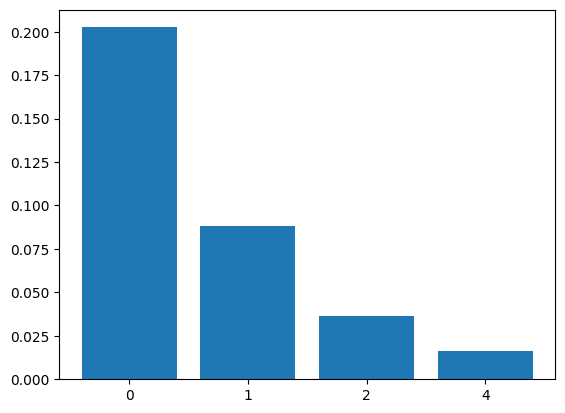

In [5]:
"""
3. Representamos claramente un gráfico de barras para concluir en este paso mostrando la imprecisión del resultado de utilizar 0 grovers
"""
plt.bar(sim_mean_error['n_grovers'].astype(str), sim_mean_error['rel_error'])

# <center> ¿Qué pasa en el mundo real? </center>

A continuación: 
1. Se cargan los datos obtenidos de múltiples ejecuciones del algoritmo en el ordenador IBMQ_MANILA
2. Se agrupan para hallar el error relativo medio de cada uno de los circuitos propuestos
3. Realizamos la comparación vs el simulador

In [6]:
"""
1. Se cargan los resultados obtenidos de las ejecuciones en un ordenador real.
"""
real_res = pd.read_csv(r"../Output/MLQAE_vFin_results_REAL_QASM_10.csv").drop(["Unnamed: 0"], axis = 1)
real_res

,n_grovers,theta_candidate,a_candidate,rel_error,n_shots,execc_index,analytical_result
0,0,0.538663,0.263158,0.464954,32,1,0.179636
1,1,0.696963,0.412025,1.293674,32,1,0.179636
2,2,0.777071,0.491674,1.737061,32,1,0.179636
3,4,0.773139,0.487742,1.715177,32,1,0.179636
4,0,0.538663,0.263158,0.464954,64,1,0.179636
...,...,...,...,...,...,...,...
235,4,0.406400,0.156266,0.130093,512,10,0.179636
236,0,0.538663,0.263158,0.464954,1024,10,0.179636
237,1,0.614025,0.331962,0.847976,1024,10,0.179636
238,2,0.589087,0.308694,0.718445,1024,10,0.179636


Error relativo medio para 1024 shots y número variable de Grovers
   n_grovers  rel_error
0          0   0.259861
1          1   0.382245
2          2   0.283437
3          4   0.239850


Error relativo mínimo para 1024 shots y número variable de Grovers
   n_grovers  rel_error
0          0   0.171963
1          1   0.182646
2          2   0.085293
3          4   0.030811


<BarContainer object of 4 artists>

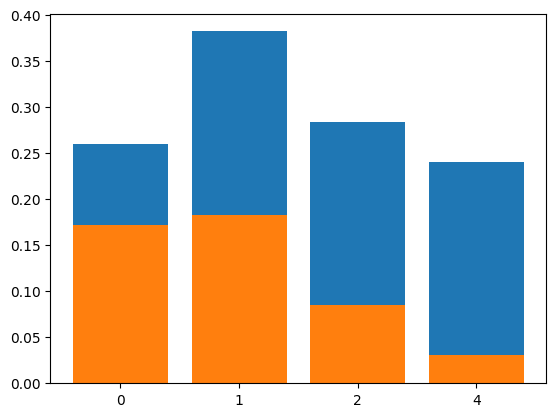

In [16]:
"""
2. Agrupamos los resultados para que se vea el error relativo de cada uno de los circuitos tras sucesivas ejecuciones. 
"""
real_mean_error = pd.DataFrame(real_res[real_res["n_shots"] == 1024].groupby(["n_grovers"])["rel_error"].mean().reset_index())
real_min_error = pd.DataFrame(real_res[real_res["n_shots"] == 1024].groupby(["n_grovers"])["rel_error"].min().reset_index())
print("Error relativo medio para 1024 shots y número variable de Grovers")
print(real_mean_error)
print("\n")
print("Error relativo mínimo para 1024 shots y número variable de Grovers")
print(real_min_error)

plt.bar(real_mean_error['n_grovers'].astype(str), real_mean_error['rel_error'])
plt.bar(real_min_error['n_grovers'].astype(str), real_min_error['rel_error'])

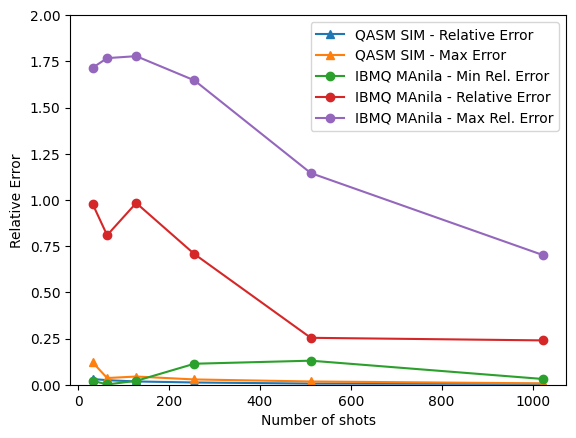

In [8]:
"""
Representamos a continuación los resultados obtenidos en el mundo real y los simuladores
"""
sim_mean_error_4_grover = pd.DataFrame(sim_res[sim_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].mean().reset_index())
sim_max_error_4_grover = pd.DataFrame(sim_res[sim_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].max().reset_index())
sim_min_error_4_grover = pd.DataFrame(sim_res[sim_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].min().reset_index())


real_mean_error_4_grover = pd.DataFrame(real_res[real_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].mean().reset_index())
real_max_error_4_grover = pd.DataFrame(real_res[real_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].max().reset_index())
real_min_error_4_grover = pd.DataFrame(real_res[real_res["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].min().reset_index())


# Plot sim
plt.plot(sim_mean_error_4_grover["n_shots"], sim_mean_error_4_grover["rel_error"], "-^")
plt.plot(sim_max_error_4_grover["n_shots"], sim_max_error_4_grover["rel_error"], "-^")

# Plot real quantum computer
plt.plot(real_min_error_4_grover["n_shots"], real_min_error_4_grover["rel_error"], "-o")
plt.plot(real_mean_error_4_grover["n_shots"], real_mean_error_4_grover["rel_error"], "-o")
plt.plot(real_max_error_4_grover["n_shots"], real_max_error_4_grover["rel_error"], "-o")


plt.ylim(0,2)
plt.xlabel("Number of shots")
plt.ylabel("Relative Error")
plt.legend(["QASM SIM - Relative Error", "QASM SIM - Max Error", "IBMQ MAnila - Min Rel. Error",
            "IBMQ MAnila - Relative Error", "IBMQ MAnila - Max Rel. Error"])

plt.show()

# Comentarios sobre este paso

A continuación: 
1. Se ha visto como lo que se predecía en el simulador se traslada al mundo real. 
2. Se ha visto en concreto el caso de los 1024. Viendo el error relativo medio y mínimo para que se vea como "gana" al resto de circuitos en precisión
3. como se puede observar en el el caso del rimer Q, parece que el error es mayor que sin ningún grover, pero, es que cuando entramos en el mundo real la profundidad del circuito importa 

# <center> Ahora bien ¿Qué nos dice el protocolo de acreditación? </center>

El protocolo de acreditación no funciona sobre los métodos de post procesamiento como el MLQAE. Funciona de forma previa, validando si la ejecución del cicuito es buena o no. Independientemente del resultado dela estimación.

# Resultados del protocolo de acreditación en un simulador ideal (sin ruido)

El protocolo de acreditación en un entorno sin ruido se puede comprobar a continuación como siempre valida positivamente la ejecución del circuito. 

Para el caso ideal SIEMPRE se acredita positivamente la ejecucion del circuito

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

test_1 = AccreditationFitter()

job = execute(circ_list, backend, shots=1)
#job = service.job("cj4cjuc3bgbqjl92p200")
result = job.result()

counts = job.result().get_counts()

# Post-process the outputs and see if the protocol accepts

for run in range(20):
    test_1.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_1.flag)
#print("Protocol run, outputs of the target",test_1.flag)

print("\nAP accepted",test_1.N_acc,"out of",test_1.num_runs,"times.")

theta = 0.05

test_1.bound_variation_distance(theta)
print("\nWith confidence",test_1.confidence,"AP certifies that VD is upper-bounded by",test_1.bound)

Protocol run number 1 , outputs of the target accepted
Protocol run number 2 , outputs of the target accepted
Protocol run number 3 , outputs of the target accepted
Protocol run number 4 , outputs of the target accepted
Protocol run number 5 , outputs of the target accepted
Protocol run number 6 , outputs of the target accepted
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target accepted
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target accepted
Protocol run number 11 , outputs of the target accepted
Protocol run number 12 , outputs of the target accepted
Protocol run number 13 , outputs of the target accepted
Protocol run number 14 , outputs of the target accepted
Protocol run number 15 , outputs of the target accepted
Protocol run number 16 , outputs of the target accepted
Protocol run number 17 , outputs of the target accepted
Protocol run number 18 , outputs of the target accepted
P

/tmp/ipykernel_81/3329403082.py:15: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_1.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_81/3329403082.py:23: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_1.bound_variation_distance(theta)


# Resultados del protocolo de acreditación en un simulador con nivel de ruido 0.0003

Para el caso con ruido NO siempre se acredita positivamente la ejecucion del circuito.
Este error ha sido escogido dado que cuando vamos al IMBQ Manila, vemos lo siguiente: "Median SX Error: 3.364e-4"

In [10]:
"""
1. Cargamos los resultados igual que antes. 
"""
accsys_result = pd.read_csv("../Output/ACC_results_on_MLQAE.csv", sep=";")
accsys_result

,n_acceptance,acc_confidence,acc_variation_distance,acc_num_traps,n_grovers,n_shots
0,21,1,0.357895,4,0,32
1,21,1,0.298246,5,0,32
2,21,1,0.255639,6,0,32
3,21,1,0.223684,7,0,32
4,21,1,0.198830,8,0,32
...,...,...,...,...,...,...
163,15,1,0.365591,6,4,1024
164,13,1,0.373431,7,4,1024
165,9,1,0.498952,8,4,1024
166,10,1,0.398883,9,4,1024


In [17]:
"""
2. se puede ver que, a medida que crece el circuito, el protocolo de acreditación funciona peor en terminos de acreditación y de variation distance.
"""
acc_mean_vd = accsys_result[accsys_result["n_shots"] == 1024].groupby(["n_grovers"])[["acc_variation_distance", "n_acceptance"]].mean().reset_index().rename(columns={"acc_variation_distance":"mean_acc"})
print("Número total de veces que se ha ejecutado el protocolo de acreditación sobre el circuito = 21")
print("Nivel de ruido equivalente al de un IBMQ Manila (0.0003 en SX)")
acc_mean_vd

Número total de veces que se ha ejecutado el protocolo de acreditación sobre el circuito = 21
Nivel de ruido equivalente al de un IBMQ Manila (0.0003 en SX)


,n_grovers,mean_acc,n_acceptance
0,0,0.248074,20.285714
1,1,0.291662,17.571429
2,2,0.361710,14.714286
3,4,0.431927,12.142857


In [15]:
resultado_df = sim_res[(sim_res["n_shots"] == 1024) & (sim_res["n_grovers"] == 4)]
print("Resultado de 10 ejecuciones en el simulador para 1024 shots y 4 grovers")
resultado_df

Resultado de 10 ejecuciones en el simulador para 1024 shots y 4 grovers


,n_grovers,theta_candidate,a_candidate,rel_error,n_shots,execc_index,analytical_result
23,4,0.436610,0.178819,0.004544,1024,1,0.179636
47,4,0.439211,0.180817,0.006575,1024,2,0.179636
71,4,0.436007,0.178357,0.007117,1024,3,0.179636
95,4,0.436173,0.178484,0.006409,1024,4,0.179636
119,4,0.436145,0.178462,0.006531,1024,5,0.179636
143,4,0.437300,0.179348,0.001598,1024,6,0.179636
167,4,0.437919,0.179824,0.001047,1024,7,0.179636
191,4,0.438547,0.180306,0.003731,1024,8,0.179636
215,4,0.439387,0.180952,0.007331,1024,9,0.179636
239,4,0.438468,0.180245,0.003392,1024,10,0.179636


# Acredtiación en un ordenador real

Para el caso real la acreditación en cambio no es positiva la mayoría de las veces
Este error ha sido escogido dado que cuando vamos al IMBQ Manila, vemos lo siguiente: "Median SX Error: 3.364e-4"

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

test_1 = AccreditationFitter()

#job = execute(circ_list, backend, shots=1)
job = service.job("cj4cjuc3bgbqjl92p200")
result = job.result()

counts = job.result().get_counts()

# Post-process the outputs and see if the protocol accepts

for run in range(20):
    test_1.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_1.flag)
#print("Protocol run, outputs of the target",test_1.flag)

print("\nAP accepted",test_1.N_acc,"out of",test_1.num_runs,"times. Variation distance not calculated -> It needs at least 1 accepeted run")

#theta = 0.05
#
#test_1.bound_variation_distance(theta)
#print("\nWith confidence",test_1.confidence,"AP certifies that VD is upper-bounded by",test_1.bound)

Protocol run number 1 , outputs of the target rejected
Protocol run number 2 , outputs of the target rejected
Protocol run number 3 , outputs of the target rejected
Protocol run number 4 , outputs of the target rejected
Protocol run number 5 , outputs of the target rejected
Protocol run number 6 , outputs of the target rejected
Protocol run number 7 , outputs of the target rejected
Protocol run number 8 , outputs of the target rejected
Protocol run number 9 , outputs of the target rejected
Protocol run number 10 , outputs of the target rejected
Protocol run number 11 , outputs of the target rejected
Protocol run number 12 , outputs of the target rejected
Protocol run number 13 , outputs of the target rejected
Protocol run number 14 , outputs of the target rejected
Protocol run number 15 , outputs of the target rejected
Protocol run number 16 , outputs of the target rejected
Protocol run number 17 , outputs of the target rejected
Protocol run number 18 , outputs of the target rejected
P

/tmp/ipykernel_81/198905227.py:15: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_1.single_protocol_run(result, postp_list, v_zero)


# Probando varias veces con distinto número de circuitos trampa: 

In [26]:
min_traps = 4
max_traps = 10


for num_trap_circs in range(min_traps,max_traps):

    test_4 = AccreditationFitter()
    for run in range(20):

        # Create target and trap circuits with different traps before just 10)
        circuit_list, postp_list, v_zero = accsys.generate_circuits(num_trap_circs)

        #job = execute(circuit_list, backend, noise_model=noise_model, basis_gates=basis_gates, shots=1)
        #result = job.result()

        job = service.job("cj4cjuc3bgbqjl92p200")
        result = job.result()
        
        # Post-process the outputs and see if the protocol accepts
        test_4.single_protocol_run(result, postp_list, v_zero)

    print("\nWith", num_trap_circs,
          "traps, AP accepted", test_4.N_acc,
          "out of", test_4.num_runs, "times.")
   

/tmp/ipykernel_81/3124214100.py:33: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_4.single_protocol_run(result, postp_list, v_zero)



With 4 traps, AP accepted 1 out of 20 times.

With 5 traps, AP accepted 0 out of 20 times.

With 6 traps, AP accepted 0 out of 20 times.

With 7 traps, AP accepted 0 out of 20 times.

With 8 traps, AP accepted 0 out of 20 times.

With 9 traps, AP accepted 0 out of 20 times.


# <center> Conclusiones </center>

- A mayor número de circuitos trama, más "difícil" es la acreditación
- A mayor número de grovers (4) mejor precisión tendremos del resultado
- Hay 2 puntos de vista para comparar las simulaciones con el mundo real:
    - Resultado del post procesamiento: el error relativo nos da una medida de lo "buena" o "mala" que ha sido nuestra ejecución a posteriori
    - Resultado del protocolo de acreditación: el ruido actual de los ordenadores cuánticos hace muy complicado acreditar las salidas ANTES de generarlas
    - Por lo tanto, tenemos un compromiso de profundidad del circuito vs. calidad de la acreditación. 

# <center> Estimacion sobre la bajada de ruido </center>

Ejecución de un circuito con una décima menor de ruido que el IBMQ Manila 3x10e-5 (0.00003)